##Data Generation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
n_data_per_class = 100
num_class = 2
dim_data = 5
n_data = n_data_per_class * num_class
n_train = n_data_per_class

mean1 = [1,0,0,0,0]
mean2 = [0,0,0,0,0]

cov1 = np.random.randn(dim_data, dim_data)
cov1 = np.dot(cov1.T, cov1)
cov2 = np.random.randn(dim_data, dim_data)
cov2 = cov1 + .001*np.dot(cov2, cov2)

data1 = np.random.multivariate_normal(mean1, cov1, n_data_per_class).astype(np.float32)
data2 = np.random.multivariate_normal(mean2, cov2, n_data_per_class).astype(np.float32)
data_x = np.vstack([data1,data2])
data_y = np.hstack([np.ones((n_data_per_class,)), -np.ones((n_data_per_class,))])

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


blues are class -1 and reds are class 1


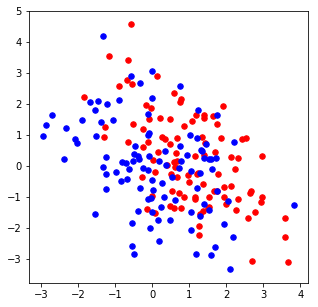

In [3]:
print 'blues are class -1 and reds are class 1'
plt.rcParams['figure.figsize']=(5,5)
plt.scatter(data1[:,0],data1[:,1],30,'r')
plt.scatter(data2[:,0],data2[:,1],30,'b')
[x1min,x1max,x2min,x2max] = plt.axis()
x1val = np.arange(x1min,x1max,0.1)
plt.axis([x1min,x1max,x2min,x2max])
plt.show()

##Logistic Regression

In [4]:
x = tf.placeholder(tf.float32, [None, dim_data])
W = tf.Variable(tf.zeros([dim_data,1]))
b = tf.Variable(tf.zeros([1]))
y_true = tf.placeholder(tf.float32, [None])

a = tf.matmul(x, W) + b
p_y = tf.sigmoid(tf.multiply(a ,tf.reshape(y_true, [-1,1]) ))

loss = tf.reduce_mean(-tf.log(p_y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(loss)



In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer())


##FDA

In [6]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)


##Compare the models

In [17]:
def run_models(num_train_data, num_training_steps=30):
    
    sess.run(tf.global_variables_initializer())
    
    wval = sess.run(W) # 2 by 1   
    bval = sess.run(b) # 1
    #print wval, bval
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), -np.ones((num_train_data,))])

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    num_test = n_data_per_class-num_train_data
    test_y = np.hstack([np.ones((num_test,)), -np.ones((num_test,))])
    
    w_history = []
    b_history = []
    acc_history = []
    for i in range(num_training_steps):
        sess.run(train_step, feed_dict={x: train_x, y_true: train_y})
        w_history.append( sess.run(W) )
        b_history.append( sess.run(b) )
        #loss_history.append( sess.run(loss, feed_dict={x: train_x, y_true: train_y}) )
    
    
        a_tst = sess.run(a, feed_dict = {x:test_x, y_true: test_y})
        n_correct_c1 = sum(a_tst[:num_test] >= 0)
        n_correct_c2 = sum(a_tst[num_test:] < 0)
        acc = (n_correct_c1 + n_correct_c2) / (float(num_test)*2)
    
        acc_history.append(acc)
    
    return w_history, b_history, acc_history

   

In [18]:
import IPython.html.widgets as widgets
from IPython.html.widgets import interact, interactive, fixed, interact_manual

In [19]:
def visualize(w_his, b_his, acc_his, iter_step, num_train_data):
    num_test = n_data_per_class-num_train_data

    
    print "accuracy of the LR: " + str(acc_his[iter_step])
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), -np.ones((num_train_data,))])

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    test_y = np.hstack([np.ones((num_test,)), -np.ones((num_test,))])

    X_lda_sklearn = sklearn_lda.fit_transform(train_x, train_y)
    transformed = sklearn_lda.transform(train_x)
    transformed = sklearn_lda.transform(test_x)

    tst_result = sklearn_lda.predict(test_x)
    n_correct_c1 = sum(tst_result[:num_test] == 1)
    n_correct_c2 = sum(tst_result[num_test:] == -1)

    acc = (n_correct_c1 + n_correct_c2) / (float(num_test)*2)
    print "accuracy of the FDA: " + str(acc)


In [20]:
#a_slider = widgets.IntSlider(min=3, max=n_data_per_class, step=1, value=3)
#w_his, b_his = widgets.interactive(run_models, num_train_data = a_slider)
num_train_data = 50
w_his, b_his, acc_his = run_models(num_train_data)
b_slider = widgets.IntSlider(min=1, max = 30, step = 1, value = 1)
w=widgets.interactive(visualize, w_his = fixed(w_his), b_his = fixed(b_his), acc_his = fixed(acc_his), num_train_data = fixed(num_train_data), iter_step = b_slider)
#w=widgets.interactive(visualize, w_his = w_his, b_his = b_his, num_train_data = num_train_data, iter_step = b_slider)
display(w)

accuracy of the LR: 0.61
accuracy of the FDA: 0.78


In [21]:
loss_lr = []
loss_fda = []

for num_train_data in range(5,50):
    _, _, acc_his_lr = run_models(num_train_data, 50)
    loss_lr.append([num_train_data, 1-acc_his_lr[-1]])
    
    train_x = np.vstack([data1[:num_train_data],data2[:num_train_data]])
    train_y = np.hstack([np.ones((num_train_data,)), np.zeros((num_train_data,))])
    
    num_test = n_data_per_class-num_train_data

    test_x = np.vstack([data1[num_train_data:],data2[num_train_data:]])
    test_y = np.hstack([np.ones((num_test,)), np.zeros((num_test,))])
     
    X_lda_sklearn = sklearn_lda.fit_transform(train_x, train_y)
    
    tst_result = sklearn_lda.predict(test_x)
    n_correct_c1 = sum(tst_result[:num_test] == 1)
    n_correct_c2 = sum(tst_result[num_test:] == 0)

    acc_fda =  (n_correct_c1 + n_correct_c2) / (float(num_test)*2) 
    loss_fda.append([num_train_data, 1-acc_fda])

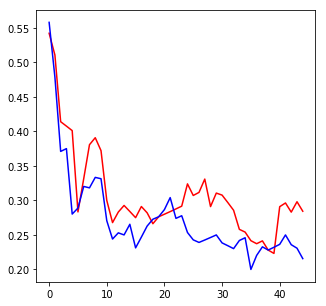

In [25]:
loss_lr = np.vstack(loss_lr)
loss_fda = np.vstack(loss_fda)
figure

plt.plot(loss_lr[:, 1], 'r')
plt.plot(loss_fda[:, 1], 'b')
#plt.scatter(loss_lr[:, 0], loss_lr[:, 1], 30, 'r')
#plt.scatter(loss_fda[:, 0], loss_fda[:, 1], 30, 'b')
plt.show()